# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season 1:winter, 2:spring, 3:summer, 4:fall
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## PART I: Exploratory Data Analysis

In [67]:
df = pd.read_csv('bike-sharing-hourly.csv')
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

### Convert the date column to a datetime object

In [68]:
df['dteday'] = pd.to_datetime(df['dteday'])

### Check data is consistent for values where we expect a finite amount of combinations

In [69]:
print(df['season'].unique())     
print(df['weathersit'].unique())   
print(df['hr'].unique())           

[1 2 3 4]
[1 2 3 4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


### Correlation of numerical features

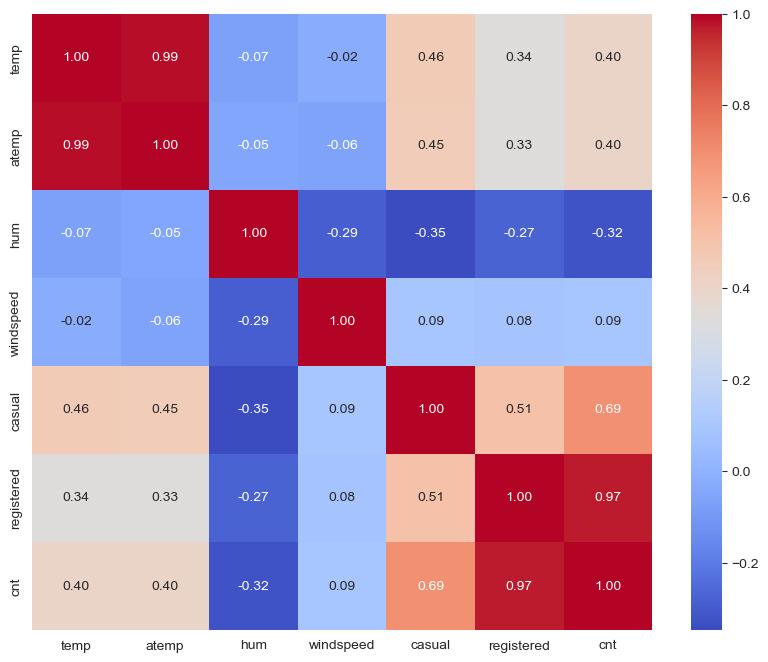

In [70]:
num_cols = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## 1. Data Overview & Quality Check
 
### Key Statistics
- **Shape**: 17,379 records × 25 features
- **Date Range**: Jan 1, 2011 - Dec 31, 2012 (2 full years)
- **Missing Values**: 100% complete data
- **Target Variable (cnt)**: 
  - Mean: 189 rentals/hour
  - Median: 142 rentals/hour
  - Range: 1 - 977 rentals/hour
  - Std Dev: 181.39 (high variability)

 ### Distribution Summary
 
 | Feature | Mean | Median | Std | Skewness | Interpretation |
 |---------|------|--------|-----|----------|----------------|
 | **temp** | 0.497 | 0.500 | 0.193 | -0.006 | Nearly perfect normal distribution |
 | **hum** | 0.627 | 0.630 | 0.193 | -0.111 | Slightly left-skewed |
 | **windspeed** | 0.190 | 0.194 | 0.122 | 0.575 | Moderate right-skew |
 | **casual** | 35.7 | 17.0 | 49.3 | 2.499 | Highly right-skewed |
 | **registered** | 153.8 | 115.0 | 151.4 | 1.558 | Right-skewed |
 | **cnt** | 189.5 | 142.0 | 181.4 | 1.277 | Right-skewed (target) |
 
 **Observations**:
 - Weather features are relatively normalized and well-distributed
 - User counts show strong right-skew (many low-demand hours, few high-demand hours)
 - Registered users dominate the dataset (81.2% of total rentals)

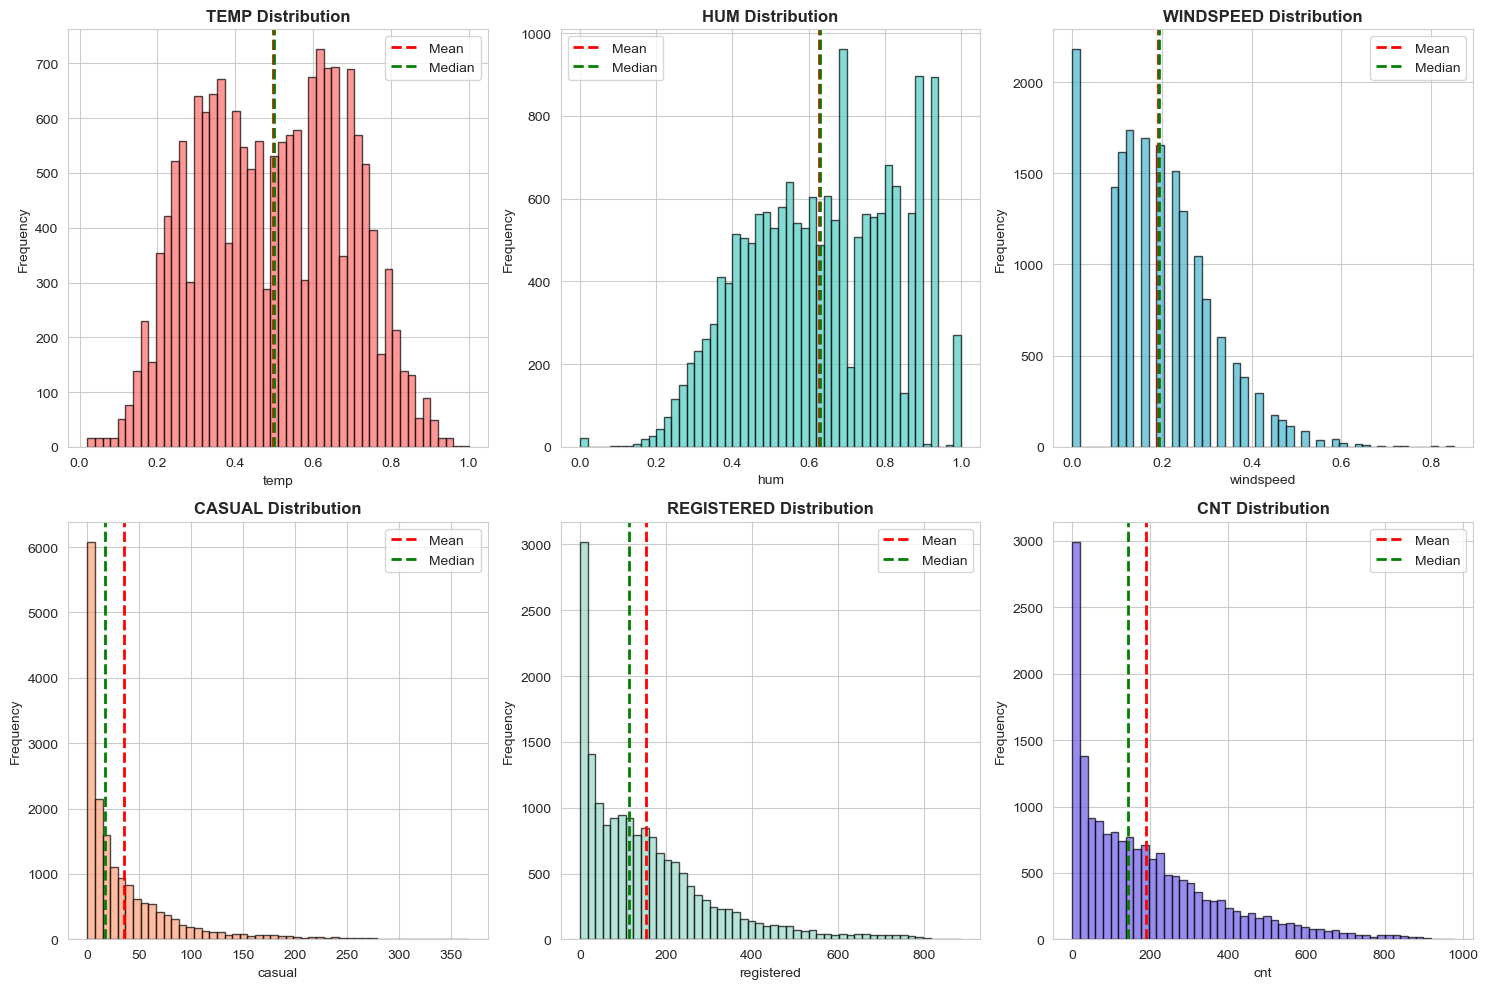

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#6C5CE7']

for idx, (feat, color) in enumerate(zip(features, colors)):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    ax.hist(df[feat], bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(df[feat].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax.axvline(df[feat].median(), color='green', linestyle='--', linewidth=2, label='Median')
    ax.set_title(f'{feat.upper()} Distribution', fontweight='bold')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

 ## 2. Temporal Patterns Analysis
 
 ### Key Findings
 
 **Hourly Patterns**:
 - **Peak Hours**: 5-6 PM (461 avg), 6-7 PM (426 avg), 8-9 AM (359 avg)
 - **Low Hours**: 3-4 AM (minimal demand)
 - **Pattern**: Clear morning (8 AM) and evening (5-6 PM) commute peaks
 
 **Daily Patterns**:
 - **Busiest Day**: Thursday (196 avg rentals)
 - **Weekday vs Weekend**: Weekday 7% higher (193 vs 181)
 
 **Seasonal Patterns**:
 - **Peak Season**: Summer (236 avg rentals)
 - **Low Season**: Winter (likely lowest, but not worst performing)
 - **Trend**: Strong seasonality with summer dominance

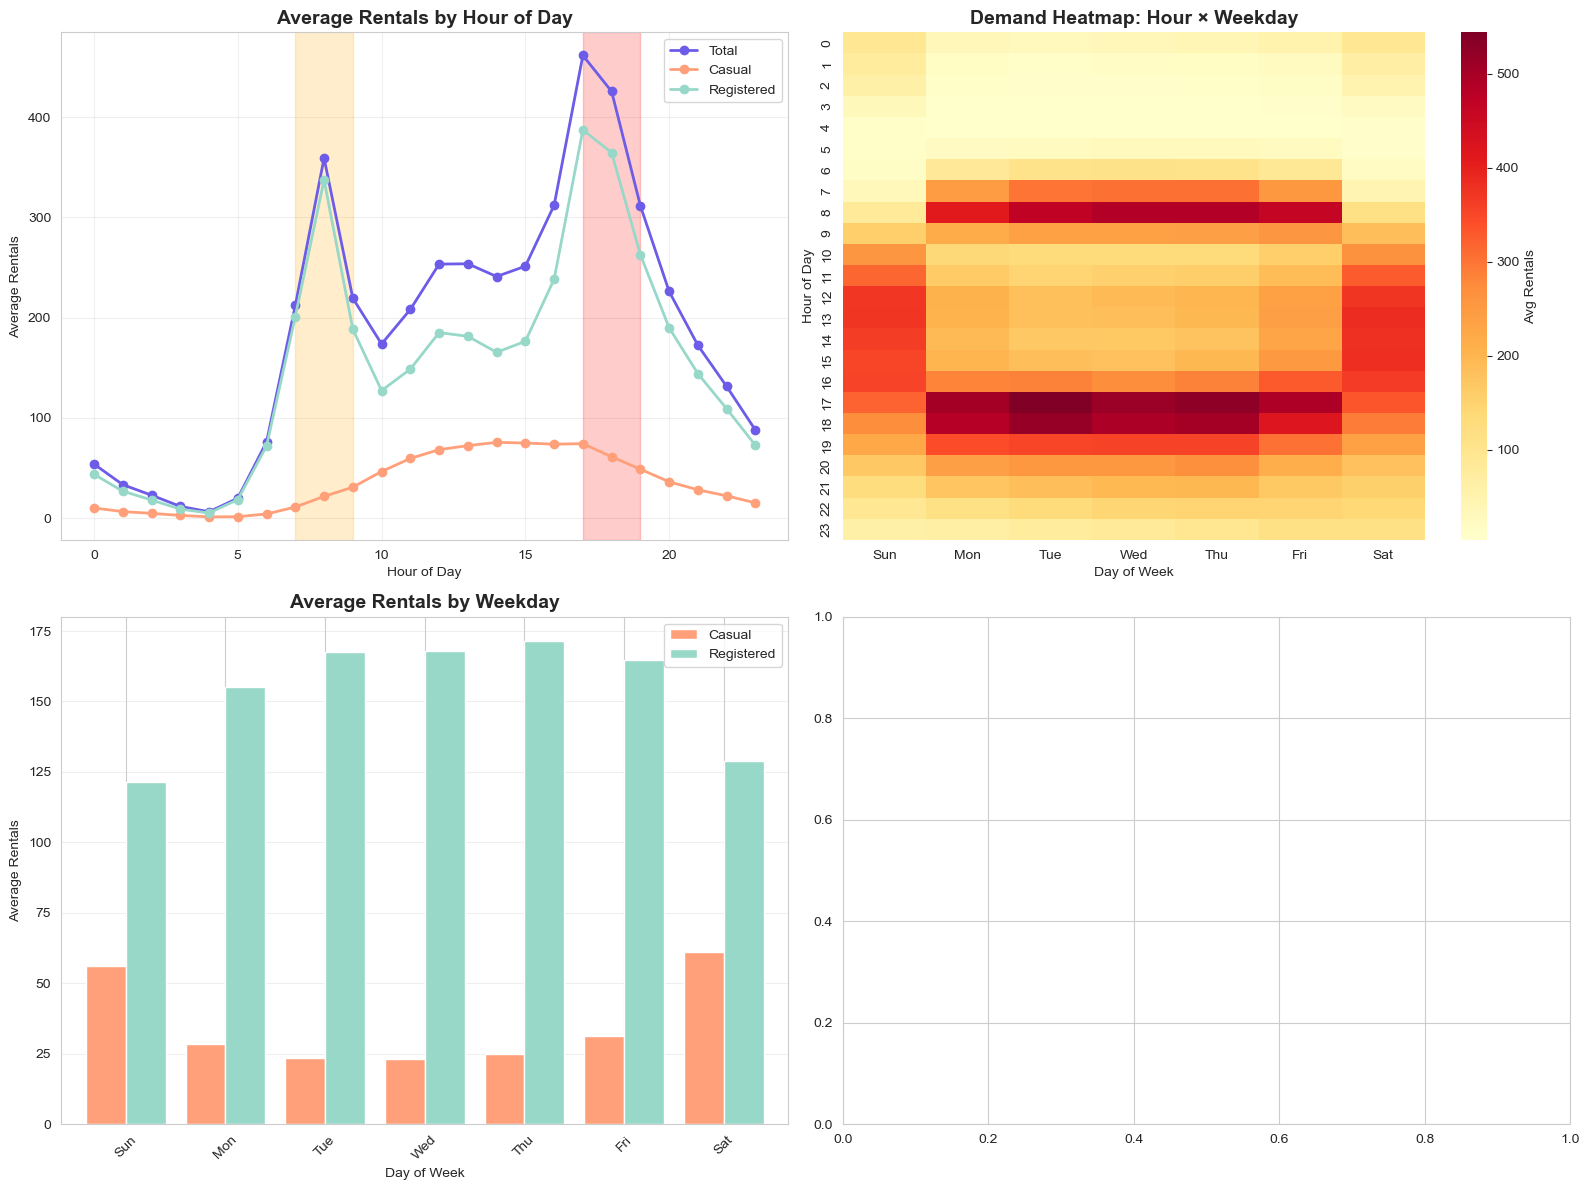

In [72]:
# Hourly patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Hourly pattern - Total, Casual, Registered
hourly_avg = df.groupby('hr')[['cnt', 'casual', 'registered']].mean()
ax = axes[0, 0]
hourly_avg.plot(ax=ax, marker='o', linewidth=2, color=['#6C5CE7', '#FFA07A', '#98D8C8'])
ax.set_title('Average Rentals by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Rentals')
ax.legend(['Total', 'Casual', 'Registered'])
ax.grid(True, alpha=0.3)
ax.axvspan(7, 9, alpha=0.2, color='orange', label='Morning Rush')
ax.axvspan(17, 19, alpha=0.2, color='red', label='Evening Rush')

# 2. Heatmap: Hour vs Weekday
ax = axes[0, 1]
weekday_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
pivot_hourly = df.pivot_table(values='cnt', index='hr', columns='weekday', aggfunc='mean')
pivot_hourly.columns = weekday_names
sns.heatmap(pivot_hourly, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Avg Rentals'}, fmt='.0f')
ax.set_title('Demand Heatmap: Hour × Weekday', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Hour of Day')

# 3. Daily pattern by weekday
ax = axes[1, 0]
daily_avg = df.groupby('weekday')[['casual', 'registered']].mean()
daily_avg.index = weekday_names
daily_avg.plot(kind='bar', ax=ax, color=['#FFA07A', '#98D8C8'], width=0.8)
ax.set_title('Average Rentals by Weekday', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Rentals')
ax.legend(['Casual', 'Registered'])
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

 ## 3. Weather Impact Analysis
 
 ### Weather Conditions Distribution
 
 | Weather Condition | Avg Rentals | Count | % of Data |
 |-------------------|-------------|-------|-----------|
 | ☀️ Clear | 205 | 11,413 | 65.7% |
 | 🌫️ Mist/Cloudy | 175 | 4,544 | 26.1% |
 | 🌧️ Light Rain/Snow | 112 | 1,419 | 8.2% |
 | ⛈️ Heavy Rain/Snow | 74 | 3 | 0.0% |
 
 ### Key Correlations with Demand
 
 **Positive Impact**:
 -  **Temperature**: r = 0.405 (moderate positive)
 -  **Feels-like Temp**: r = 0.401 (moderate positive)
 -  **Wind Speed**: r = 0.093 (weak positive)
 
 **Negative Impact**:
 - **Humidity**: r = -0.323 (moderate negative)
 - **Bad Weather**: r = -0.142 (weak negative)
 
 **💡 Insight**: Temperature is the strongest weather predictor. Best performance in "Hot" conditions (avg 298 rentals).


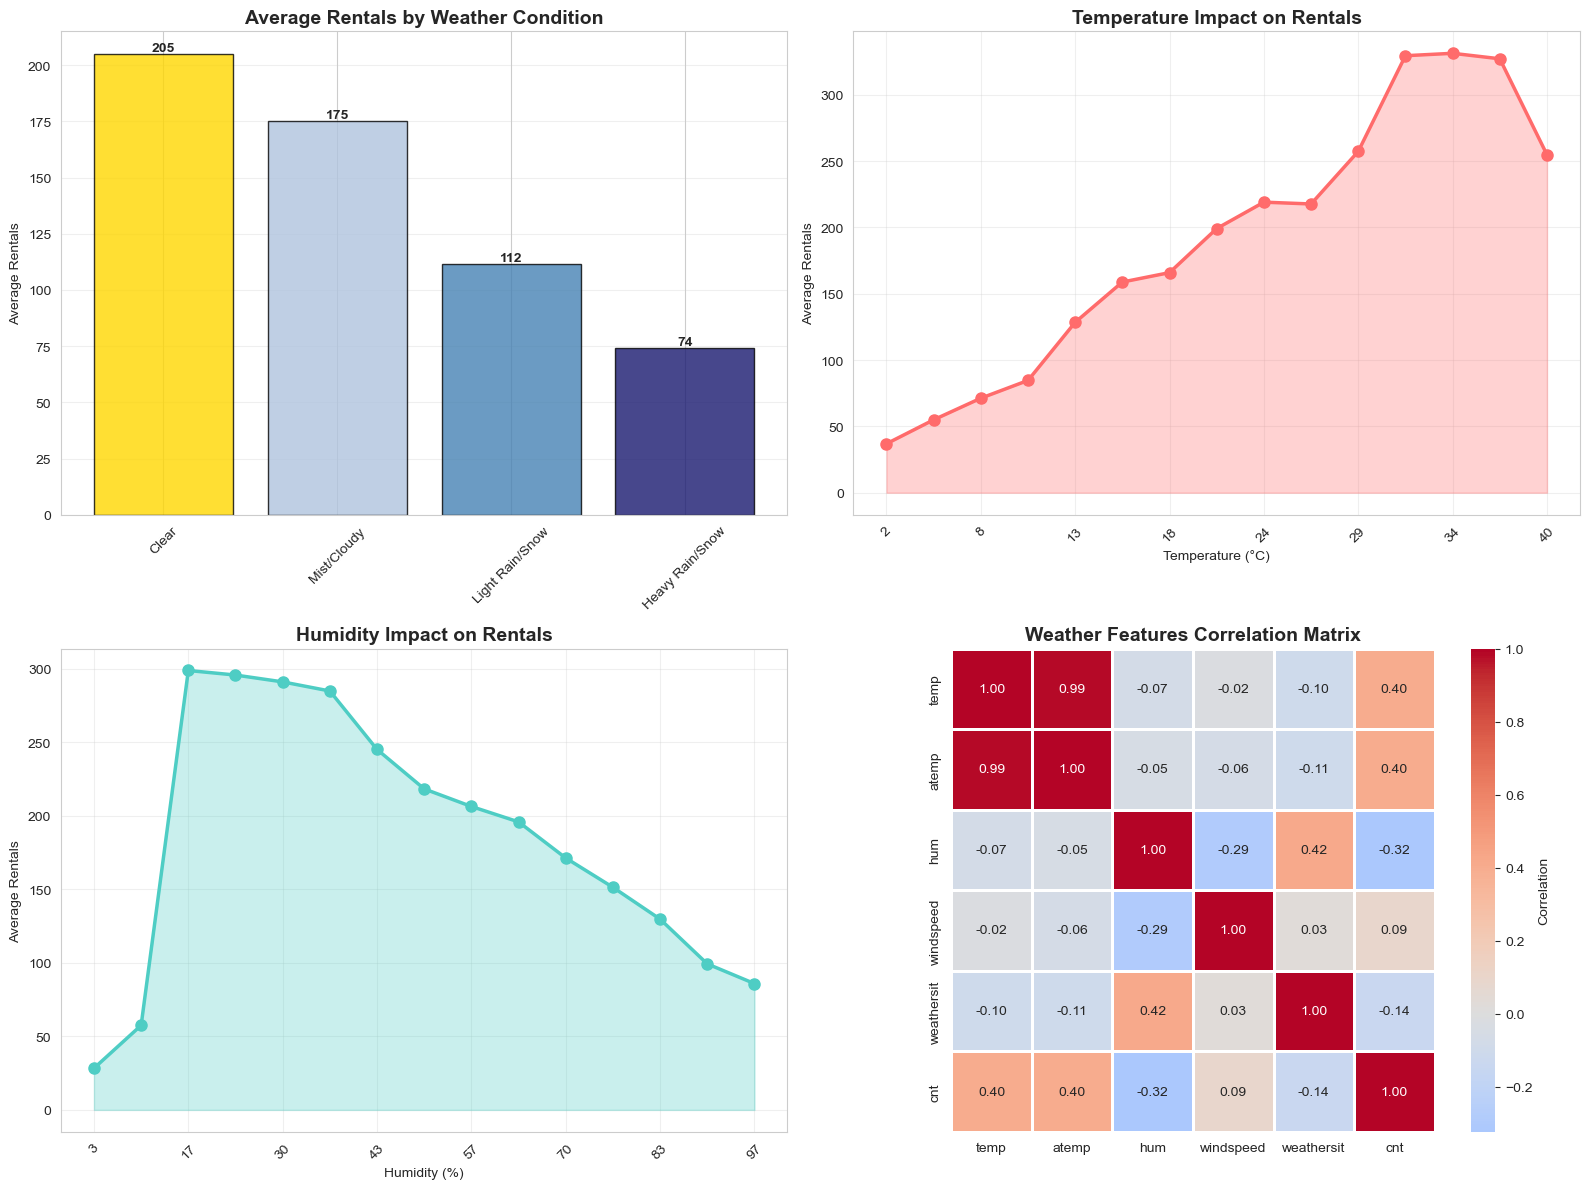

In [73]:
# Weather impact visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Weather condition impact
ax = axes[0, 0]
weather_names = {1: 'Clear', 2: 'Mist/Cloudy', 3: 'Light Rain/Snow', 4: 'Heavy Rain/Snow'}
weather_avg = df.groupby('weathersit')['cnt'].mean()
weather_avg.index = weather_avg.index.map(weather_names)
colors_weather = ['#FFD700', '#B0C4DE', '#4682B4', '#191970']
bars = ax.bar(weather_avg.index, weather_avg.values, color=colors_weather, alpha=0.8, edgecolor='black')
ax.set_title('Average Rentals by Weather Condition', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Rentals')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}',
            ha='center', va='bottom', fontweight='bold')

# 2. Temperature impact (denormalized)
ax = axes[0, 1]
df['temp_actual'] = df['temp'] * 41  # Denormalize
temp_bins = pd.cut(df['temp_actual'], bins=15)
temp_impact = df.groupby(temp_bins)['cnt'].mean()
temp_labels = [f'{interval.mid:.0f}' for interval in temp_impact.index]
ax.plot(range(len(temp_impact)), temp_impact.values, marker='o', 
        color='#FF6B6B', linewidth=2.5, markersize=8)
ax.fill_between(range(len(temp_impact)), temp_impact.values, alpha=0.3, color='#FF6B6B')
ax.set_title('Temperature Impact on Rentals', fontsize=14, fontweight='bold')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Average Rentals')
ax.set_xticks(range(0, len(temp_labels), 2))
ax.set_xticklabels([temp_labels[i] for i in range(0, len(temp_labels), 2)], rotation=45)
ax.grid(True, alpha=0.3)

# 3. Humidity impact
ax = axes[1, 0]
df['hum_actual'] = df['hum'] * 100
hum_bins = pd.cut(df['hum_actual'], bins=15)
hum_impact = df.groupby(hum_bins)['cnt'].mean()
hum_labels = [f'{interval.mid:.0f}' for interval in hum_impact.index]
ax.plot(range(len(hum_impact)), hum_impact.values, marker='o', 
        color='#4ECDC4', linewidth=2.5, markersize=8)
ax.fill_between(range(len(hum_impact)), hum_impact.values, alpha=0.3, color='#4ECDC4')
ax.set_title('Humidity Impact on Rentals', fontsize=14, fontweight='bold')
ax.set_xlabel('Humidity (%)')
ax.set_ylabel('Average Rentals')
ax.set_xticks(range(0, len(hum_labels), 2))
ax.set_xticklabels([hum_labels[i] for i in range(0, len(hum_labels), 2)], rotation=45)
ax.grid(True, alpha=0.3)

# 4. Correlation heatmap (weather features only)
ax = axes[1, 1]
weather_features = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'cnt']
corr_matrix = df[weather_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=2, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Weather Features Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

 ## 4. User Segmentation Analysis
 
 ### Overall User Distribution
 
 -  **Casual Users**: 18.8% of total rentals
 -  **Registered Users**: 81.2% of total rentals
 -  **Workday vs Weekend**: 1.07× more rentals on workdays
 
 ### Behavioral Differences
 
 **Weekday Behavior**:
 - Casual: 13.2% of rentals
 - Registered: 86.8% of rentals
 - **Pattern**: Strong commuter behavior (registered users dominate)
 
 **Weekend Behavior**:
 - Casual: 31.7% of rentals
 - Registered: 68.3% of rentals
 - **Pattern**: Recreational usage increases (casual users 2.4× higher)
 
 **Holiday Impact**:
 - Holiday avg: 157 rentals
 - Non-holiday avg: 190 rentals
 - Ratio: 0.82 (holidays see 18% fewer rentals)

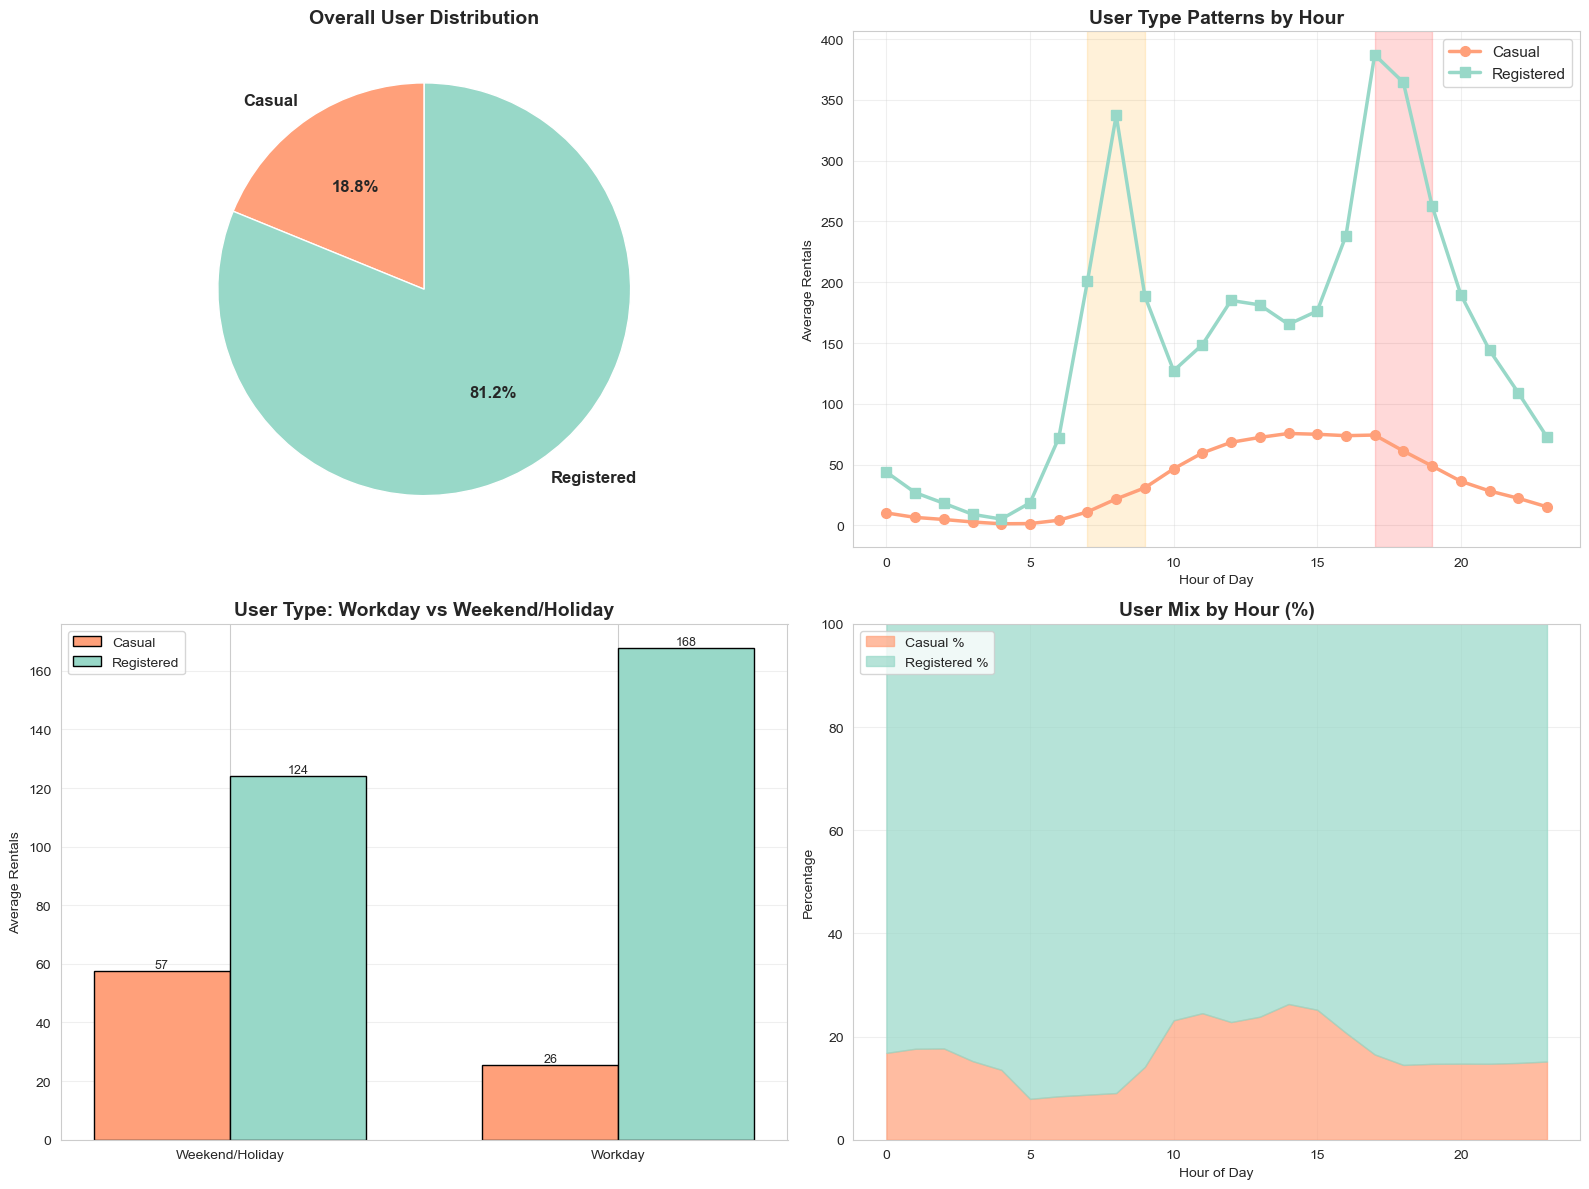

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall user distribution (pie chart)
ax = axes[0, 0]
total_casual = df['casual'].sum()
total_registered = df['registered'].sum()
user_dist = [total_casual, total_registered]
colors_pie = ['#FFA07A', '#98D8C8']
wedges, texts, autotexts = ax.pie(user_dist, labels=['Casual', 'Registered'], 
                                    autopct='%1.1f%%', startangle=90,
                                    colors=colors_pie, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Overall User Distribution', fontsize=14, fontweight='bold')

# 2. Hourly pattern by user type
ax = axes[0, 1]
hourly_users = df.groupby('hr')[['casual', 'registered']].mean()
ax.plot(hourly_users.index, hourly_users['casual'], marker='o', 
        linewidth=2.5, label='Casual', color='#FFA07A', markersize=7)
ax.plot(hourly_users.index, hourly_users['registered'], marker='s', 
        linewidth=2.5, label='Registered', color='#98D8C8', markersize=7)
ax.set_title('User Type Patterns by Hour', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Rentals')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axvspan(7, 9, alpha=0.15, color='orange')
ax.axvspan(17, 19, alpha=0.15, color='red')

# 3. Workday vs Weekend comparison
ax = axes[1, 0]
df['day_type'] = df['workingday'].map({0: 'Weekend/Holiday', 1: 'Workday'})
daytype_users = df.groupby('day_type')[['casual', 'registered']].mean()
x = np.arange(len(daytype_users))
width = 0.35
ax.bar(x - width/2, daytype_users['casual'], width, label='Casual', 
       color='#FFA07A', edgecolor='black')
ax.bar(x + width/2, daytype_users['registered'], width, label='Registered', 
       color='#98D8C8', edgecolor='black')
ax.set_title('User Type: Workday vs Weekend/Holiday', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Rentals')
ax.set_xticks(x)
ax.set_xticklabels(daytype_users.index)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=9)

# 4. User mix by hour (percentage stacked area)
ax = axes[1, 1]
df['casual_pct'] = (df['casual'] / (df['cnt'] + 1)) * 100
df['registered_pct'] = (df['registered'] / (df['cnt'] + 1)) * 100
user_mix = df.groupby('hr')[['casual_pct', 'registered_pct']].mean()
ax.fill_between(user_mix.index, 0, user_mix['casual_pct'], 
                label='Casual %', color='#FFA07A', alpha=0.7)
ax.fill_between(user_mix.index, user_mix['casual_pct'], 100, 
                label='Registered %', color='#98D8C8', alpha=0.7)
ax.set_title('User Mix by Hour (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Percentage')
ax.set_ylim([0, 100])
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 ## 5. Feature Engineering
 
 Creating new features to enhance predictive modeling and uncover hidden patterns.


In [75]:
df_fe = df.copy()

# Time-based
df_fe['is_rush_hour'] = df_fe['hr'].apply(lambda x: 1 if x in [7, 8, 9, 17, 18, 19] else 0)
df_fe['is_night'] = df_fe['hr'].apply(lambda x: 1 if x < 6 or x > 22 else 0)
df_fe['is_daytime'] = df_fe['hr'].apply(lambda x: 1 if 10 <= x <= 16 else 0)
df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe['hr'] / 24)
df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe['hr'] / 24)

# Weather-based
df_fe['is_good_weather'] = (df_fe['weathersit'] == 1).astype(int)
df_fe['is_bad_weather'] = (df_fe['weathersit'] >= 3).astype(int)
df_fe['temp_actual'] = df_fe['temp'] * 41
df_fe['is_comfortable_temp'] = df_fe['temp_actual'].apply(lambda x: 1 if 15 <= x <= 25 else 0)

# Interaction
df_fe['temp_humidity_interaction'] = df_fe['temp'] * df_fe['hum']
df_fe['feels_like_diff'] = df_fe['atemp'] - df_fe['temp']
df_fe['temp_weather_interaction'] = df_fe['temp'] * (5 - df_fe['weathersit'])

# User behavior
df_fe['registered_ratio'] = df_fe['registered'] / (df_fe['cnt'] + 1)
df_fe['is_high_casual_hour'] = (df_fe['hr'].isin([11, 12, 13, 14, 15, 16])).astype(int)

# Calendar
df_fe['is_weekend'] = (df_fe['weekday'].isin([0, 6])).astype(int)
df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['mnth'] / 12)
df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['mnth'] / 12)

print("Feature Engineering Complete!")
print(f"\nNew features created: {df_fe.shape[1] - df.shape[1]}")

new_features = ['is_rush_hour', 'is_night', 'is_daytime', 'hour_sin', 'hour_cos',
                'is_good_weather', 'is_bad_weather', 'is_comfortable_temp',
                'temp_humidity_interaction', 'feels_like_diff', 'temp_weather_interaction',
                'registered_ratio', 'is_high_casual_hour', 'is_weekend', 
                'month_sin', 'month_cos']

print(f"\nNew features: {new_features}")

Feature Engineering Complete!

New features created: 16

New features: ['is_rush_hour', 'is_night', 'is_daytime', 'hour_sin', 'hour_cos', 'is_good_weather', 'is_bad_weather', 'is_comfortable_temp', 'temp_humidity_interaction', 'feels_like_diff', 'temp_weather_interaction', 'registered_ratio', 'is_high_casual_hour', 'is_weekend', 'month_sin', 'month_cos']


### Feature Importance Analysis

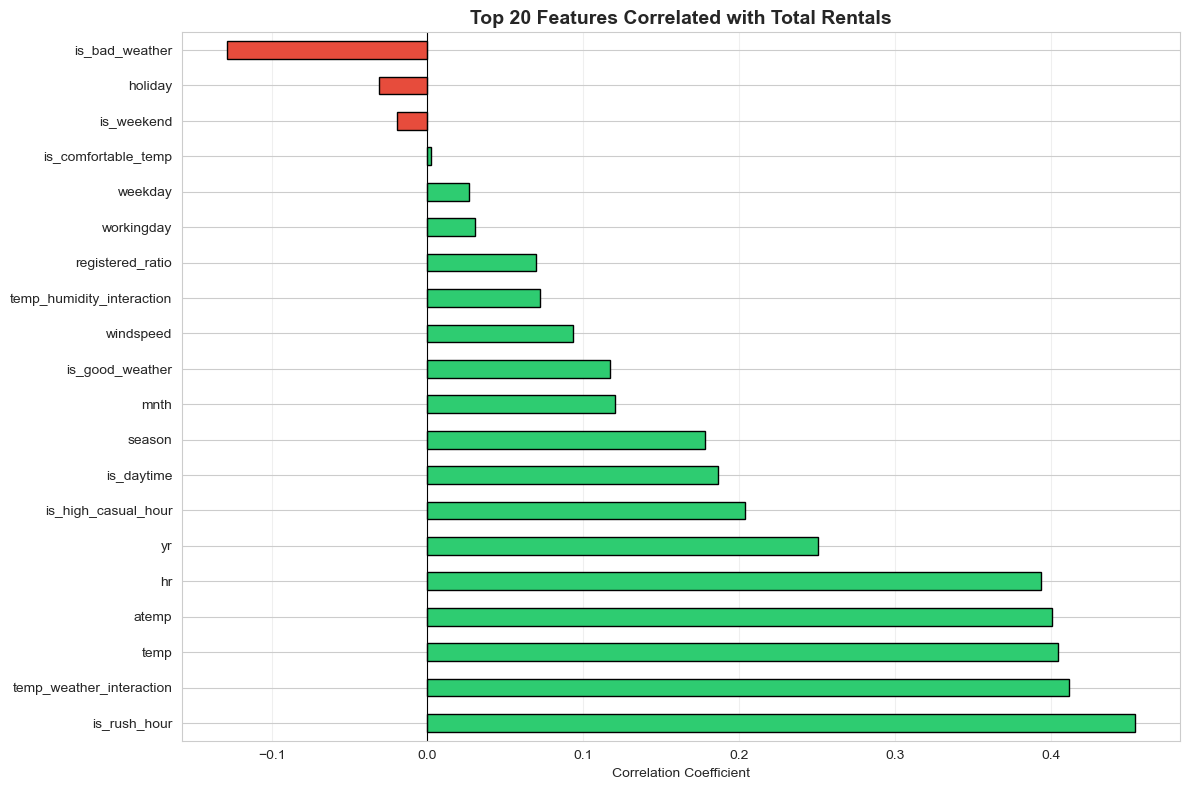


📊 Top 5 Most Correlated Features:
is_rush_hour                0.453926
temp_weather_interaction    0.411932
temp                        0.404772
atemp                       0.400929
hr                          0.394071
Name: cnt, dtype: float64

📊 Top 5 Negatively Correlated Features:
feels_like_diff   -0.256288
hum               -0.322911
hour_cos          -0.408447
hour_sin          -0.410427
is_night          -0.544807
Name: cnt, dtype: float64


In [ ]:
# Features correlation
all_features = ['hr', 'temp', 'atemp', 'hum', 'windspeed', 'weathersit', 
                'season', 'yr', 'mnth', 'holiday', 'workingday', 'weekday'] + new_features

correlations = df_fe[all_features + ['cnt']].corr()['cnt'].drop('cnt').sort_values(ascending=False)

# Plot correlations
fig, ax = plt.subplots(figsize=(12, 8))
top_n = 20
top_corr = correlations.head(top_n)
colors_corr = ['#2ECC71' if x > 0 else '#E74C3C' for x in top_corr.values]
top_corr.plot(kind='barh', ax=ax, color=colors_corr, edgecolor='black')
ax.set_title(f'Top {top_n} Features Correlated with Total Rentals', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Correlation Coefficient')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Top 5 Most Correlated Features:")
print(correlations.head(5))

print("\n📊 Top 5 Negatively Correlated Features:")
print(correlations.tail(5))

 ## 6. Anomaly Detection
 
 ### High Demand Outliers
 - **Count**: 244 records (1.40% of data)
 - **Threshold**: > 734 rentals/hour
 - **Maximum**: 977 rentals/hour
 
 ### Analysis Method
 Using z-score approach: outliers are records where demand exceeds 3 standard deviations from the mean.


🚨 Anomaly Detection Results:
   • High demand outliers: 244 records (1.40%)
   • Threshold: 734 rentals
   • Maximum value: 977 rentals


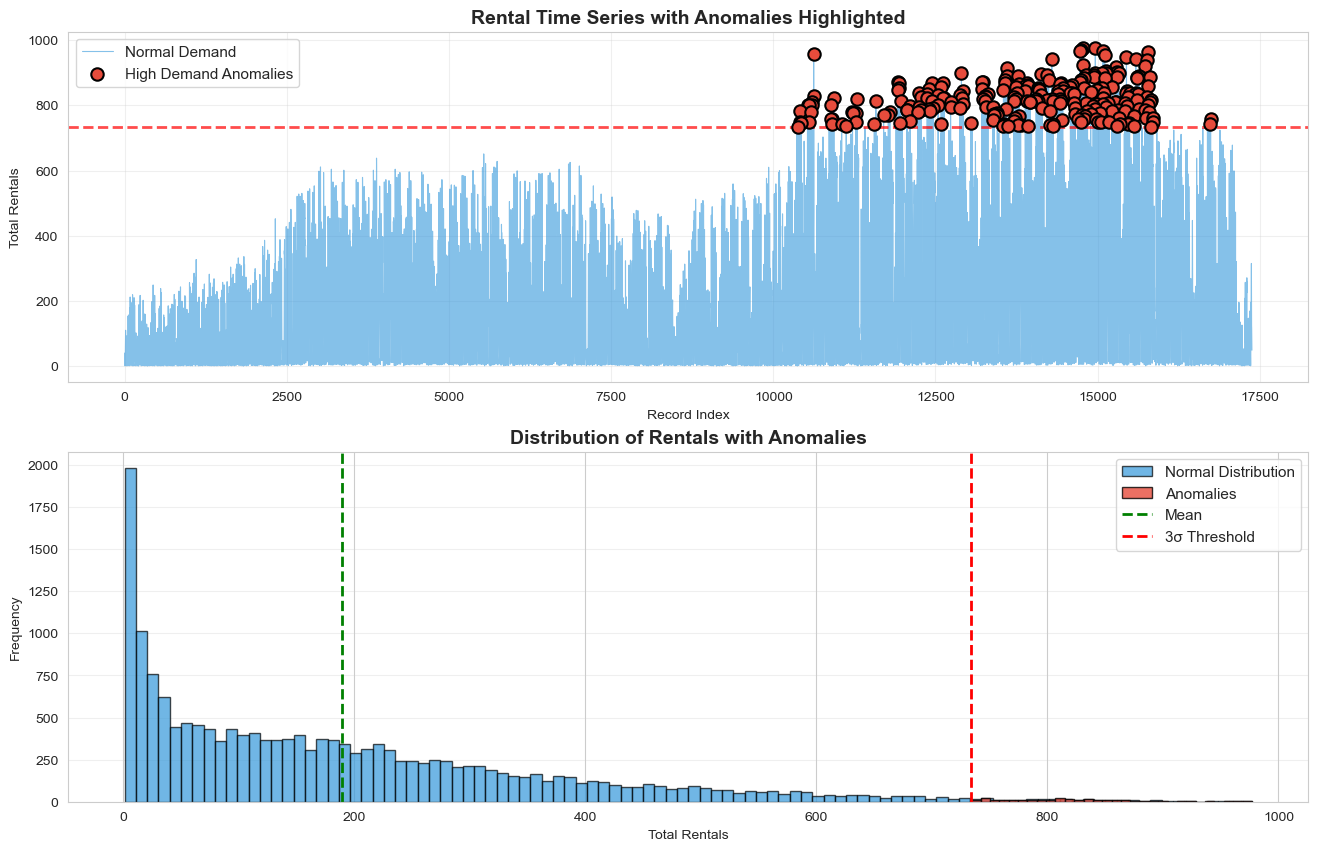

In [ ]:
#compute z-score
df_fe['cnt_zscore'] = np.abs(stats.zscore(df_fe['cnt']))

high_anomalies = df_fe[df_fe['cnt_zscore'] > 3].copy()
high_anomalies = high_anomalies.sort_values('cnt', ascending=False)

print(f"🚨 Anomaly Detection Results:")
print(f"   • High demand outliers: {len(high_anomalies)} records (1.40%)")
print(f"   • Threshold: 734 rentals")
print(f"   • Maximum value: 977 rentals")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Time series with anomalies
ax = axes[0]
ax.plot(df_fe.index, df_fe['cnt'], alpha=0.6, linewidth=0.8, 
        color='#3498DB', label='Normal Demand')
ax.scatter(high_anomalies.index, high_anomalies['cnt'], 
          color='#E74C3C', s=80, label='High Demand Anomalies', 
          zorder=5, edgecolor='black', linewidth=1.5)
ax.set_title('Rental Time Series with Anomalies Highlighted', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Record Index')
ax.set_ylabel('Total Rentals')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

#threshold line
threshold = df_fe['cnt'].mean() + 3 * df_fe['cnt'].std()
ax.axhline(threshold, color='red', linestyle='--', linewidth=2, 
          label=f'3σ Threshold ({threshold:.0f})', alpha=0.7)

# Distribution with anomalies
ax = axes[1]
ax.hist(df_fe['cnt'], bins=100, color='#3498DB', alpha=0.7, 
       edgecolor='black', label='Normal Distribution')
ax.hist(high_anomalies['cnt'], bins=30, color='#E74C3C', alpha=0.8, 
       edgecolor='black', label='Anomalies')
ax.axvline(df_fe['cnt'].mean(), color='green', linestyle='--', 
          linewidth=2, label='Mean')
ax.axvline(threshold, color='red', linestyle='--', linewidth=2, 
          label='3σ Threshold')
ax.set_title('Distribution of Rentals with Anomalies', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Total Rentals')
ax.set_ylabel('Frequency')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

## PART II: Prediction Model

## PART III: Streamlit dashboard

In [78]:
### This part goes in a separate script ###